<a href="https://colab.research.google.com/github/Simon-creator-jara/Inteligencia_artificial/blob/main/Trabajo_Mapa_DEFINITIVO_ENVIAR_MULTIPLE_VIAJE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TRABAJO INTRODUCCIÓN A LA INTELIGENCIA ARTIFICIAL

## Andrés, Cristian, Simón Jaramillo, Simón Gómez

In [ ]:
!pip install osmnx

     |████████████████████████████████| 95 kB 2.5 MB/s 
     |████████████████████████████████| 1.0 MB 40.9 MB/s 
     |████████████████████████████████| 1.0 MB 39.4 MB/s 
     |████████████████████████████████| 11.2 MB 42.7 MB/s 
     |████████████████████████████████| 6.3 MB 38.5 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
     |████████████████████████████████| 16.7 MB 252 kB/s 
     |████████████████████████████████| 929 kB 11.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires reque

In [ ]:
!pip install plotly_express

In [ ]:
#Importamos las librerías necesarias.
import pydot
from IPython.display import Image, display
import queue
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString

import matplotlib.pyplot as plt
import plotly_express as px
import networkx as nx
import osmnx as ox
import math
import pdb

#Mapa


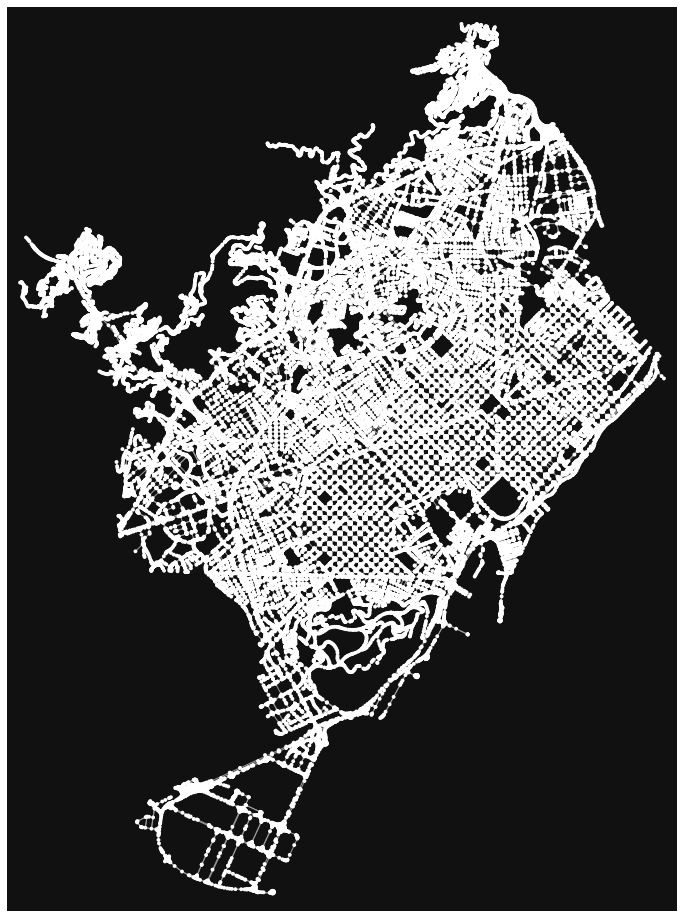

(<Figure size 864x2880 with 1 Axes>, <AxesSubplot:>)

In [ ]:
#En este caso se trabajará con el mapa de la ciudad de Barcelona.
G = ox.graph_from_place('Barcelona, Cataluña, España', network_type='drive',simplify=False)
ox.plot_graph(G,figsize=(12,40))

In [ ]:
#Colocamos una velocidad promedio para todos los tipos de vía (En Km/h); esto lo hicimos sacando la media en la tabla de las csv.
hwy_speeds = {'living_street': 20,
              'motorway': 85,
              'motorway_link': 75,
              'primary': 50,
              'primary_link': 50,
              'residential': 30,
              'secondary': 50,
              'secondary_link': 50,
              'tertiary': 40,
              'tertiary_link': 35,
              'trunk': 75,
              'trunk_link': 60,
              'unclassified': 35
              }
G = ox.add_edge_speeds(G,hwy_speeds)              
G = ox.add_edge_travel_times(G)

In [ ]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [ ]:
gdf_edges.head()

osmid  oneway lanes                      name  \
u        v          key                                                      
13019203 540056267  0    245676679    True     7           Plaça d'Espanya   
21638843 6831738685 0      4079500   False     3  Passeig de Joan de Borbó   
         5252624458 0    543357596   False     3  Passeig de Joan de Borbó   
21638844 21638845   0      4079500   False     3  Passeig de Joan de Borbó   
         3509499616 0      4079500   False     3  Passeig de Joan de Borbó   

                             highway maxspeed width  length  speed_kph  \
u        v          key                                                  
13019203 540056267  0        primary       50    28   8.483       50.0   
21638843 6831738685 0    residential       30   NaN   9.343       30.0   
         5252624458 0    residential       30   NaN  19.492       30.0   
21638844 21638845   0    residential       30   NaN   9.748       30.0   
         3509499616 0    residential       30   NaN   9.570       30.0   

                         travel_time access  ref junction est_width bridge  \
u        v          key                                                      
13019203 540056267  0            0.6    NaN  NaN      NaN       NaN    NaN   
21638843 6831738685 0            1.1    NaN  NaN      NaN       NaN    NaN   
         5252624458 0            2.3    NaN  NaN      NaN       NaN    NaN   
21638844 21638845   0            1.2    NaN  NaN      NaN       NaN    NaN   
         3509499616 0            1.1    NaN  NaN      NaN       NaN    NaN   

                        tunnel  \
u        v          key          
13019203 540056267  0      NaN   
21638843 6831738685 0      NaN   
         5252624458 0      NaN   
21638844 21638845   0      NaN   
         3509499616 0      NaN   

                                                                geometry  
u        v          key                                                   
13019203 540056267  0    LINESTRING (2.14944 41.37539, 2.14935 41.37542)  
21638843 6831738685 0    LINESTRING (2.18759 41.37036, 2.18763 41.37028)  
         5252624458 0    LINESTRING (2.18759 41.37036, 2.18761 41.37054)  
21638844 21638845   0    LINESTRING (2.18769 41.37017, 2.18774 41.37009)  
         3509499616 0    LINESTRING (2.18769 41.37017, 2.18765 41.37025)

#Clases

##Nodo

In [ ]:
#Definimos la clase nodo, con sus estados, valores, y sus "hijos".
class Node ():
  def __init__(self,state,value,operator=None, parent=None,objective=None):
    self.state= state
    self.value = value
    self.children = []
    self.parent=parent
    self.operator=operator
    self.objective=objective
    self.level=0
    
  def add_child(self, value, state, operator):
    node=type(self)(value=value, state=state, operator=operator,parent=self)
    node.level=node.parent.level+1
    self.children.append(node)
    return node
  
  def add_node_child(self, node):
    node.level=node.parent.level+1
    self.children.append(node)    
    return node

  #Devuelve todos los estados según los operadores aplicados.
  def getchildrens(self):
    return [
        self.getState(i) 
          if not self.repeatStatePath(self.getState(i)) 
            else None for i, op in enumerate(self.operators)]
    
  def getState(self, index):
    pass
  
  def __eq__(self, other):
    return self.state == other.state
 
  def __lt__(self, other):
    return self.f() < other.f()

  def repeatStatePath(self, state):
      n=self
      while n is not None and n.state!=state:
          n=n.parent
      return n is not None
    
  def pathObjective(self):
      n=self
      result=[]
      while n is not None:
          result.append(n)
          n=n.parent
      return result
  
  def heuristic(self):
    return 0
  
  def cost(self):
    return 1
  
  def f(self): 
    print(self.cost()+self.heuristic())
    return self.cost()+self.heuristic()

##Árbol

In [ ]:
#Creamos la clase del árbol, que en este caso tendrá las diferentes posibilidades de viajes.
class Tree ():
  def __init__(self, root):
    self.root=root

  def printPath(self,n):
    stack=n.pathObjective()
    path=stack.copy()
    while len(stack)!=0:
        node=stack.pop()
        if node.operator is not None and node.parent.operators is not None:
            print(f'operador:  {node.parent.operators[node.operator]} \t estado: {node.state}')
        else:
            print(f' {node.state}')
    return path

  def givePath(self,n):
    r=[]
    stack=n.pathObjective()
    path=stack.copy()
    while len(stack)!=0:
      node=stack.pop()
      if node.parent is not None:
        if node.operator is not None:
          try:
            r.append(node.parent.operators[node.operator])
          except IndexError:
            pdb.set_trace()
    return r  

  def reinitRoot(self):
    self.root.operator=None
    self.root.parent=None
    self.root.objective=None
    self.root.children = []
    self.root.level=0

  #El método que funciona únicamente con la heurística, BestFirst.
  def bestFirst(self,endState):
    self.reinitRoot()
    pq=queue.PriorityQueue()
    pq.put((self.root.heuristic(),self.root))
    while not pq.empty():
      node=pq.get()[1]
      print(f"El nodo que entra a bestFirst es:{node}")
      children=node.getchildrens()
      print(f"Los hijos son:{children}")
      for i,child in enumerate(children):
        if child is not None:
          newChild=node.add_child(value=node.value+'-'+str(i), 
                                  state=child, operator=i)
          pq.put((newChild.heuristic(),newChild))
          if endState==child:
            return newChild

  ##El método que funciona con heurística y costo, A Asterisc.
  def Aasterisk(self,endState):
    self.reinitRoot()
    pq=queue.PriorityQueue()
    pq.put((self.root.f(),self.root))
    while not pq.empty():
      node=pq.get()[1]
      children=node.getchildrens()
      for i,child in enumerate(children):
        if child is not None:
          newChild=node.add_child(value=node.value+'-'+str(i), 
                                  state=child, operator=i)
          #print(f"Hijo nuevo:{newChild.state}")
          pq.put((newChild.f(),newChild))
          if endState==child:
            return newChild
  


##Route Map

In [ ]:
class RouteMap(Node):
  #Definiendo mapa como una variable static
  mapa=None
  endState=None
  x_inicial=None
  y_inicial=None
  x_final=None
  y_final=None
  edge_final=None
  d_init=None
  edges=None
  df_edges=None
  name_final=None
  #En estos atributos voy a colocar las entradas del dataframe que corresponden al mismo nombre, o sea que cada nodo de este mapa tendrá su nombre de avenida, y su velocidad.
  highway_final=None
  oneway_final=None
  lanes_final=None
  speed_kph=None
  #En adición, nuestra heurística tiene una dependencia en el tipo de transporte o viaje que se vaya a hacer, por eso necesitamos esta otra entrada.
  TipoV=None
  def __init__(self,mapa=None,initState=None,endState=None,TipoV=None,**kwargs):
    super(RouteMap, self).__init__(**kwargs)
    if mapa is not None:
      RouteMap.mapa=mapa
    if endState is not None:
      RouteMap.endState=endState
    if initState is not None:
      RouteMap.initState=initState
    if TipoV is not None:
      RouteMap.TipoV=TipoV
    if RouteMap.edges is None and RouteMap.df_edges is None:
      RouteMap.edges=list(RouteMap.mapa.edges)    
    if RouteMap.mapa is not None and RouteMap.df_edges is None:
      RouteMap.df_edges = ox.graph_to_gdfs(RouteMap.mapa)[1]

    self.adj=self.adj()
    if RouteMap.x_inicial is None:
      RouteMap.x_inicial=RouteMap.mapa.nodes[self.initState]['x']
    if RouteMap.y_inicial is None:
      RouteMap.y_inicial=RouteMap.mapa.nodes[self.initState]['y']
    if RouteMap.x_final is None:    
      RouteMap.x_final=RouteMap.mapa.nodes[self.endState]['x']
    if RouteMap.y_final is None:  
      RouteMap.y_final=RouteMap.mapa.nodes[self.endState]['y']
    if RouteMap.edge_final is None:  
      RouteMap.edge_final=ox.distance.nearest_edges(RouteMap.mapa, RouteMap.x_final,RouteMap.y_final)
    if RouteMap.d_init is None:  
      RouteMap.d_init=ox.distance.euclidean_dist_vec( RouteMap.y_inicial , RouteMap.x_inicial , RouteMap.y_final , RouteMap.x_final ) 

    if RouteMap.name_final is None:  
      try:
        RouteMap.name_final=  RouteMap.mapa.edges[RouteMap.edge_final]['name']
      except:
        RouteMap.name_final=0
    if RouteMap.highway_final is None:  
      try:
        RouteMap.highway_final=RouteMap.mapa.edges[RouteMap.edge_final]['highway']
      except:
        RouteMap.highway_final=0
    if RouteMap.oneway_final is None:  
      try:
        RouteMap.oneway_final=RouteMap.mapa.edges[RouteMap.edge_final]['oneway']
      except:
        RouteMap.oneway_final=0
    if RouteMap.lanes_final is None:  
      try:
        RouteMap.lanes_final= int(RouteMap.mapa.edges[RouteMap.edge_final]['lanes'])
      except:
        RouteMap.lanes_final=0

    if RouteMap.speed_kph is None:  
      try:
        RouteMap.speed_kph=RouteMap.mapa.edges[RouteMap.edge_final]['speed_kph']
      except:
        RouteMap.speed_kph=0

    self.operators=self.adj  

    if self.parent is not None:
      self.parentcost=self.parent.cost()


  def adj(self):
    state=self.state
    edges=RouteMap.edges
    nodes=[]
    for i in range(len(edges)):
      if edges[i][0]==self.state:
        nodes.append(edges[i][1])
    result=[a if not self.repeatStatePath(a) else None for a in nodes]
    #print(f"Adyacentes:{result}")
    return result

  def getState(self, index): 
    if len(self.adj)>0:
        for node in self.adj:
            if (self.operators[index]==node):
                #print(f"operadores:{self.operators[index]}")
                return self.operators[index]          
    return None
  
  def cost(self):
    if self.parent is not None:
      for a in self.parent.adj:
        if a==self.state:
          # Se expresa el tiempo de segundos a horas
          travel_time = RouteMap.df_edges.loc[self.parent.state,self.state,0]['travel_time']/3600

          costo=self.parentcost+travel_time
    else:
      costo=0
    return costo
  
  def dist(self):
    if self.parent is not None:
      for a in self.parent.adj:
        if a==self.state:

          dist = RouteMap.df_edges.loc[self.parent.state,self.state,0]['length']

          recorrido=self.parent.dist()+dist
    else:
      recorrido=0
    return recorrido

  def heuristic(self):
    print(f"State heuristica:{self.state}")
    x=RouteMap.mapa.nodes[self.state]['x']
    y=RouteMap.mapa.nodes[self.state]['y']

    # Se da mayor peso para que sea comprarable al costo
    d=ox.distance.euclidean_dist_vec( y , x , RouteMap.y_final , RouteMap.x_final )

    flag=0
    result=0
    #Si no es la raíz, vamos a agregarle al nodo los detalles del tipo de calle, líneas, y kilometraje, para poder acceder a los mismos.
    if self.parent is not None:
      name = RouteMap.df_edges.loc[self.parent.state,self.state,0]['name']
    if self.parent is not None:
      highway = RouteMap.df_edges.loc[self.parent.state,self.state,0]['highway']
    if self.parent is not None: 
      oneway = RouteMap.df_edges.loc[self.parent.state,self.state,0]['oneway']
    if self.parent is not None:
      lanes = RouteMap.df_edges.loc[self.parent.state,self.state,0]['lanes']
    if self.parent is not None:
      speed = RouteMap.df_edges.loc[self.parent.state,self.state,0]['speed_kph']
    if self.parent is not None:
      bridge = RouteMap.df_edges.loc[self.parent.state,self.state,0]['bridge']

    #Si por alguna razón el problema está teniendo demasiados problemas llegando al destino, o no puede, entonces levanta una Flag.
    if self.parent is not None:

      #El tipo de viaje 1 o turístico, procuran no utilizar vías primarias, sino entrar por calles pequeñas (para ver más sitios).
      if RouteMap.TipoV==2 and self.dist()<2000:
        if highway not in ['motorway','motorway_link','primary','primary_link'] :
          result=result+100+d
        else:
          result=result+d

        if d> RouteMap.d_init :
          result=result+d+10
        else:
          result=result+d

        #Un tercer tipo de viaje es para las personas que practican o aprenden a usar coche; en tal caso se castigan las rutas de alta velocidad y la distancia.
      elif RouteMap.TipoV==3 and self.dist()<2000:
        if speed > 40:
          result=result+100
        if d > RouteMap.d_init:
          result=result+d+10
        #La condición de 2000 se hace para evitar que por buscar una de estar rutas tan específicas, el problema nunca encuentre un objetivo; por eso le dijimos que si viaja más de 2 km (por cada una de las ramas) y no ha encontrado su objetivo, entonces que olvide esa heurística y simplemente desarrolle el problema por distancia.
      
        #En último lugar, el viaje 0 o general, que es aquel donde únicamente se pondera llegar o recorrer la mínima distancia posible (en el menor tiempo, pero este es parte del costo, no de la heurística).
      elif RouteMap.TipoV==0 and self.dist()<700:
        if d > RouteMap.d_init:
          result=result+d+10     
        else:
          result=result+d 
      
        #Esta heurística variará según el tipo de viaje que decida realizarse.
      else:
        
        flag=1
        speed_kph = RouteMap.df_edges.loc[self.parent.state,self.state,0]['speed_kph']
        if speed_kph != 0:

          result = (d*1000) / speed_kph
        else:

          result = 999999

    #Si se ha levantado la bandera, entonces el mensaje que se imprime es el siguiente.
    if flag==1:
      print(f"Intento realizarse el tipo de transporte {RouteMap.TipoV} pero se tomaron rutas poco óptimas por lo que se utiliza heurística de distancia")

     

    if self.parent is not None:
      print(f"Highway:{highway}")
      print(f"Distancia inicial entre nodo inicial y final:{RouteMap.d_init}")
      print(f"Velocidad:{speed}")
    print(f"Resultado:{result}")
    print(f"dist:{self.dist()}")

    return result

#Ejecución

In [ ]:
start = (41.4039462422786, 2.1726654799378053)
end = (41.38101715754148, 2.1191187958647872)
#start=(41.37418754170101, 2.108112753011722)
#end=(41.38275749994636, 2.122747634871159)
#En este caso, como las coordenadas pueden no estar necesariamente en un nodo, entonces tomamos el más cercano.
start_node = ox.distance.nearest_nodes(G, start[1],start[0]) 
end_node = ox.distance.nearest_nodes(G, end[1],end[0])

In [ ]:
#Se crea el Nodo con la clase RouteMap
node_1=RouteMap(mapa=G, initState=start_node,endState=end_node,value="inicio",state=start_node,TipoV=3)
ruta=Tree(node_1)

In [ ]:
objective=ruta.Aasterisk(end_node)

Se han truncado las últimas 5000 líneas del flujo de salida.
Highway:primary
Distancia inicial entre nodo inicial y final:0.05821287223673043
Velocidad:50.0
Resultado:0.6271640754156153
dist:4540.453999999998
State heuristica:6245249321
Intento realizarse el tipo de transporte 3 pero se tomaron rutas poco óptimas por lo que se utiliza heurística de distancia
Highway:primary
Distancia inicial entre nodo inicial y final:0.05821287223673043
Velocidad:50.0
Resultado:0.6234496745046703
dist:4558.513999999998
0.7808385633935592
State heuristica:6245249321
Intento realizarse el tipo de transporte 3 pero se tomaron rutas poco óptimas por lo que se utiliza heurística de distancia
Highway:primary
Distancia inicial entre nodo inicial y final:0.05821287223673043
Velocidad:50.0
Resultado:0.6234496745046703
dist:4558.513999999998
State heuristica:409003535
Intento realizarse el tipo de transporte 3 pero se tomaron rutas poco óptimas por lo que se utiliza heurística de distancia
Highway:primary
Dista

In [ ]:
result=ruta.givePath(objective)

In [ ]:
#Imprime los nodos que se atravesaron para llegar
path=ruta.printPath(objective)

 5344717239
operador:  1396408886 	 estado: 1396408886
operador:  7685732966 	 estado: 7685732966
operador:  3196848709 	 estado: 3196848709
operador:  30555972 	 estado: 30555972
operador:  1860476053 	 estado: 1860476053
operador:  1860476043 	 estado: 1860476043
operador:  6480465991 	 estado: 6480465991
operador:  3207273277 	 estado: 3207273277
operador:  8109649162 	 estado: 8109649162
operador:  30254194 	 estado: 30254194
operador:  3207273278 	 estado: 3207273278
operador:  8109649164 	 estado: 8109649164
operador:  3207273293 	 estado: 3207273293
operador:  9565645285 	 estado: 9565645285
operador:  30243160 	 estado: 30243160
operador:  7232838065 	 estado: 7232838065
operador:  3207273295 	 estado: 3207273295
operador:  3207273311 	 estado: 3207273311
operador:  7575264741 	 estado: 7575264741
operador:  30243117 	 estado: 30243117
operador:  3207273310 	 estado: 3207273310
operador:  3207273344 	 estado: 3207273344
operador:  8109649154 	 estado: 8109649154
operador:  1267

In [ ]:
#Listas con todos los puntos objetivos de la ruta, junto con su tiempo de viaje.
node_start = []
node_end = []
X_to = []
Y_to = []
X_from = []
Y_from = []
length = []
travel_time = []
for u, v in zip(result[:-1], result[1:]):
    node_start.append(u)
    node_end.append(v)
    length.append(round(G.edges[(u, v, 0)]['length']))
    travel_time.append(round(G.edges[(u, v, 0)]['travel_time']))
    X_from.append(G.nodes[u]['x'])
    Y_from.append(G.nodes[u]['y'])
    X_to.append(G.nodes[v]['x'])
    Y_to.append(G.nodes[v]['y'])

In [ ]:
#Estos datos en lista se colocan dentro de un DataFrame.
df = pd.DataFrame(list(zip(node_start, node_end, X_from, Y_from,  X_to, Y_to, length, travel_time)), 
               columns =["node_start", "node_end", "X_from", "Y_from",  "X_to", "Y_to", "length", "travel_time"]) 
df.head()

,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time
0,1396408886,7685732966,2.172619,41.403931,2.172916,41.403700,36,3
1,7685732966,3196848709,2.172916,41.403700,2.172929,41.403690,2,0
2,3196848709,30555972,2.172929,41.403690,2.173161,41.403509,28,2
3,30555972,1860476053,2.173161,41.403509,2.172954,41.403354,24,3
4,1860476053,1860476043,2.172954,41.403354,2.172623,41.403106,39,5


In [ ]:
#Reiniciamos índices y printeamos el DataFrame
df.reset_index(inplace=True)
df.head()

,index,node_start,node_end,X_from,Y_from,X_to,Y_to,length,travel_time
0,0,1396408886,7685732966,2.172619,41.403931,2.172916,41.403700,36,3
1,1,7685732966,3196848709,2.172916,41.403700,2.172929,41.403690,2,0
2,2,3196848709,30555972,2.172929,41.403690,2.173161,41.403509,28,2
3,3,30555972,1860476053,2.173161,41.403509,2.172954,41.403354,24,3
4,4,1860476053,1860476043,2.172954,41.403354,2.172623,41.403106,39,5


In [ ]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_from, df.Y_from))
gdf["geometry_to"] = [Point(xy) for xy in zip(gdf.X_to, gdf.Y_to)]
gdf['line'] = gdf.apply(lambda row: LineString([row['geometry_to'], row['geometry']]), axis=1)
line_gdf = gdf[["node_start","node_end","length","travel_time", "line"]].set_geometry('line')

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



# Viaje 1

In [ ]:
px.scatter_mapbox(gdf, lon= "X_from", lat="Y_from", zoom=12,mapbox_style='stamen-terrain')

# Viaje 2

In [ ]:
px.scatter_mapbox(gdf, lon= "X_from", lat="Y_from", zoom=12,mapbox_style='stamen-terrain')

# Viaje 3

In [ ]:
px.scatter_mapbox(gdf, lon= "X_from", lat="Y_from", zoom=12,mapbox_style='stamen-terrain')

In [ ]:
#Imprimimos la longitud y lo que aproximadamente tarda (según el travel time del DataFrame).
route_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, result, 'length')))
route_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, result, 'travel_time')))
print('La ruta seleccionada tiene una longitud de', route_length, 'metros y tarda en aproximado', route_time, 'segundos.')

La ruta seleccionada tiene una longitud de 7522 metros y tarda en aproximado 585 segundos.
